# Getting Data

In [1]:
import datetime
import holidays
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pickle
import polars as pl

import constants
from setup_and_validation import download_data, validate_data

In [2]:
df = download_data(constants.URL_DATA)
df.head(5)

date,state,blood_type,donations
date,str,str,i64
2006-01-01,"""Johor""","""all""",87
2006-01-02,"""Johor""","""all""",15
2006-01-03,"""Johor""","""all""",8
2006-01-04,"""Johor""","""all""",33
2006-01-05,"""Johor""","""all""",20


In [3]:
# For reproducibility, only using data up to and including June 5, 2025
# This is to ensure that the data used in the notebook is consistent
df = df.filter(pl.col("date") < datetime.date(2025, 6, 6))

In [4]:
validate_data(df)

All rows have been validated successfully.
No duplicated rows detected.


In [5]:
print(f"We have {df.height} rows. Let's check the contents.")

We have 461240 rows. Let's check the contents.


In [6]:
print(f"Number of days: {df['date'].n_unique()}")
print(f"Number of blood types: {df['blood_type'].n_unique()}")
print(f"Number of states: {df['state'].n_unique()}")

Number of days: 7096
Number of blood types: 5
Number of states: 13


In [7]:
assert df.height == df['date'].n_unique() * df['blood_type'].n_unique() * df['state'].n_unique()

Now, we could confirm that we have exactly one row per date, state , and blood type combination.

In [8]:
# We have the 'all' column which should be exactly equal to the sum of the four blood types. 

grouped_df = df.filter(pl.col('blood_type') != 'all').group_by(['state', 'date']).agg(pl.col('donations').sum())
df_exp = df.filter(pl.col('blood_type') == 'all')
comp_df = df_exp.join(
    grouped_df, 
    on=['date', 'state'], 
    how='inner'
).with_columns((pl.col('donations') - pl.col('donations_right')).alias('diff'))

diff_df = comp_df.filter(pl.col('diff') != 0)
diff_df

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2015-06-03,"""W.P. Kuala Lumpur""","""all""",657,656,1
2025-03-23,"""Selangor""","""all""",250,249,1
2020-04-08,"""Selangor""","""all""",54,53,1
2020-11-19,"""W.P. Kuala Lumpur""","""all""",353,352,1
2018-04-07,"""W.P. Kuala Lumpur""","""all""",605,604,1
…,…,…,…,…,…
2014-05-21,"""W.P. Kuala Lumpur""","""all""",569,568,1
2022-07-12,"""W.P. Kuala Lumpur""","""all""",373,372,1
2012-11-13,"""W.P. Kuala Lumpur""","""all""",192,191,1


It seems that 216 rows have mismatches, we can further check how 'severe' these mismatches are.

In [9]:
print(diff_df['diff'].max())
print(diff_df['diff'].min())

3
1


In [10]:
# Differences seem not too bad, but let's check
diff_df.sort('diff', descending=True)

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2022-09-15,"""W.P. Kuala Lumpur""","""all""",577,574,3
2024-01-09,"""W.P. Kuala Lumpur""","""all""",450,448,2
2013-04-08,"""W.P. Kuala Lumpur""","""all""",315,313,2
2007-10-30,"""W.P. Kuala Lumpur""","""all""",445,443,2
2013-01-16,"""W.P. Kuala Lumpur""","""all""",712,710,2
…,…,…,…,…,…
2014-05-21,"""W.P. Kuala Lumpur""","""all""",569,568,1
2022-07-12,"""W.P. Kuala Lumpur""","""all""",373,372,1
2012-11-13,"""W.P. Kuala Lumpur""","""all""",192,191,1


We see some differences / data issues. However, in the grand scheme of things, the differences are relatively minor and we can just replace the 'all' column with a sum of the other values.

In [11]:
# We regroup this by pivoting the table
df = df.pivot(
    values="donations",
    index=["date", "state"],
    on="blood_type"
).drop('all')
df.head(5)

date,state,a,b,o,ab
date,str,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3
2006-01-02,"""Johor""",4,3,6,2
2006-01-03,"""Johor""",2,2,4,0
2006-01-04,"""Johor""",7,11,12,3
2006-01-05,"""Johor""",3,8,8,1


In [12]:
df = df.with_columns(pl.sum_horizontal(["a", "b", "o", "ab"]).alias("all"))
df.head(5)

date,state,a,b,o,ab,all
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3,87
2006-01-02,"""Johor""",4,3,6,2,15
2006-01-03,"""Johor""",2,2,4,0,8
2006-01-04,"""Johor""",7,11,12,3,33
2006-01-05,"""Johor""",3,8,8,1,20


In [13]:
# Before moving on with visualizations, we can dump the data to a pickle file
with open('blood_donations.pkl', 'wb') as file:
    pickle.dump(df, file)

# Visualization

For the time being, we will drop the 'state' column and look at the nationwide level.

In [14]:
df_all = df.group_by(pl.col('date')).sum().drop('state').sort('date')
df_all

date,a,b,o,ab,all
date,i64,i64,i64,i64,i64
2006-01-01,152,139,194,40,525
2006-01-02,53,43,112,19,227
2006-01-03,29,21,56,6,112
2006-01-04,92,98,165,36,391
2006-01-05,149,198,193,42,582
…,…,…,…,…,…
2025-06-01,556,589,1056,65,2266
2025-06-02,442,509,781,60,1792
2025-06-03,282,293,460,49,1084


We will only look at training and validation data so that insights from the test data cannot go inside the exploratory analysis.

In [15]:
df_exp = df_all[:int(df_all.height * (constants.TRAIN_FRAC + constants.VAL_FRAC))]
df_exp

date,a,b,o,ab,all
date,i64,i64,i64,i64,i64
2006-01-01,152,139,194,40,525
2006-01-02,53,43,112,19,227
2006-01-03,29,21,56,6,112
2006-01-04,92,98,165,36,391
2006-01-05,149,198,193,42,582
…,…,…,…,…,…
2024-06-11,393,439,706,61,1599
2024-06-12,364,450,672,65,1551
2024-06-13,383,413,630,78,1504


In [16]:
df_weekly = (
    df_exp
    .with_columns(
        [
            pl.col('date').dt.week().alias('week'),
            pl.col('date').dt.year().alias('year')
        ]
    )
    .group_by(['year', 'week'])
    .agg([
        pl.all().sum(),
        pl.len().alias('days_in_week')
    ])
    .sort('year', 'week')
    .drop('date')
    .with_columns(
        pl.concat_str(pl.col('year'), pl.col('week'), separator='-').alias('yearweek')
    )
)

df_weekly

year,week,a,b,o,ab,all,days_in_week,yearweek
i32,i8,i64,i64,i64,i64,i64,u32,str
2006,1,664,677,1014,194,2549,7,"""2006-1"""
2006,2,747,785,1181,183,2896,7,"""2006-2"""
2006,3,1322,1439,2138,323,5222,7,"""2006-3"""
2006,4,954,1038,1475,241,3708,7,"""2006-4"""
2006,5,416,481,751,118,1766,7,"""2006-5"""
…,…,…,…,…,…,…,…,…
2024,20,2985,3279,5278,637,12179,7,"""2024-20"""
2024,21,3154,3509,5382,760,12805,7,"""2024-21"""
2024,22,2510,2863,4292,613,10278,7,"""2024-22"""


In [17]:
# We remove last week since it only holds 1 day
df_weekly = df_weekly[:-1].drop('days_in_week')

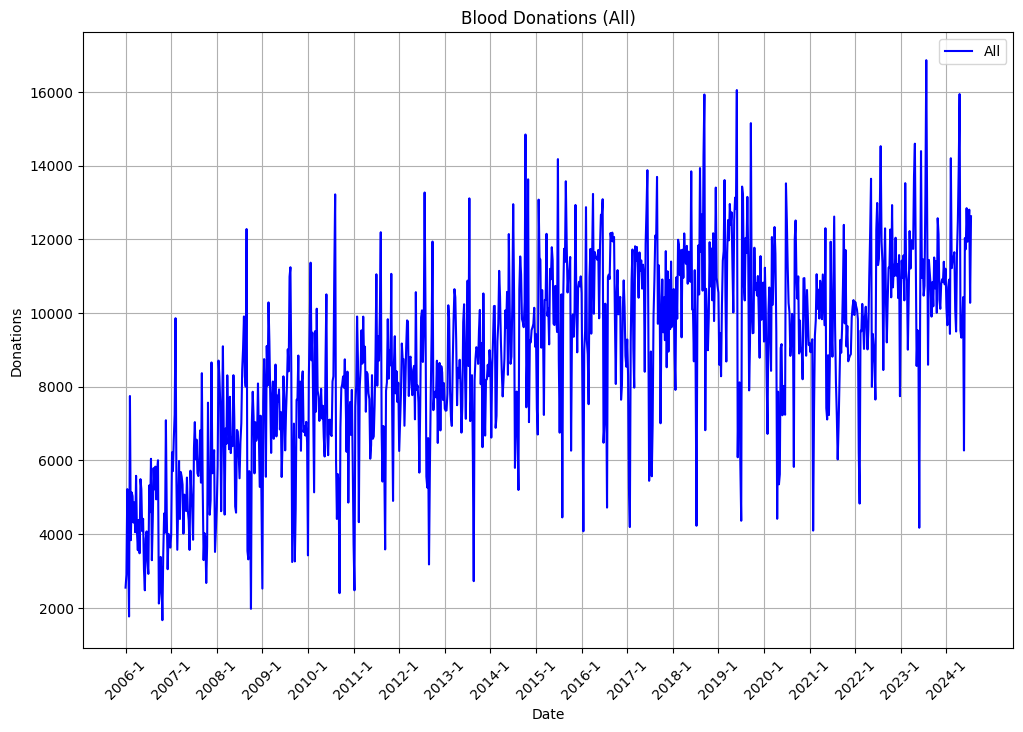

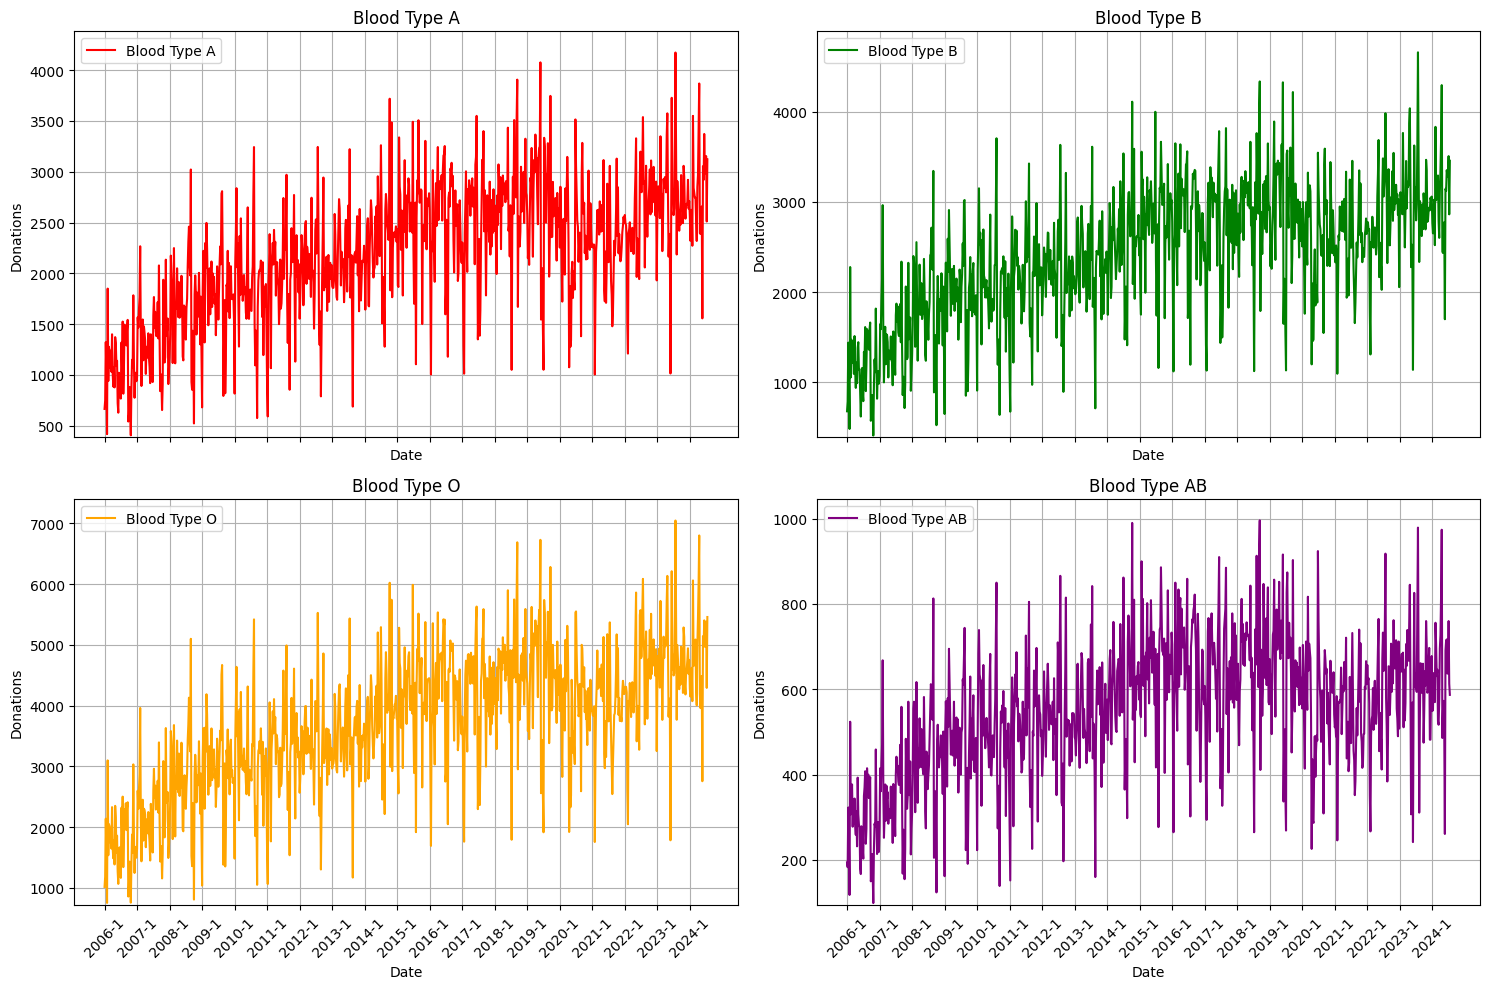

In [18]:
# Plot for the 'all' column
plt.figure(figsize=(12, 8))
plt.plot(df_weekly['yearweek'], df_weekly['all'], label='All', color='blue')
plt.title('Blood Donations (All)')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Set x-axis ticks to the first week of each year
year_ticks = df_weekly.filter(pl.col('week') == 1)['yearweek']
plt.xticks(ticks=range(0, len(df_weekly['yearweek']), 52),  # Approximate yearly interval
           labels=year_ticks, rotation=45)  # Rotate for readability

plt.show()

# 2x2 plot for 'a', 'b', 'o', and 'ab' columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)

columns = ['a', 'b', 'o', 'ab']
titles = ['Blood Type A', 'Blood Type B', 'Blood Type O', 'Blood Type AB']
colors = ['red', 'green', 'orange', 'purple']

for i, ax in enumerate(axes.flat):
    col = columns[i]
    # Compute min/max for this blood type
    ymin = df_weekly[col].min()
    ymax = df_weekly[col].max()
    ax.plot(df_weekly['yearweek'], df_weekly[col], label=titles[i], color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Donations')
    ax.legend()
    ax.grid()
    ax.set_ylim(ymin * 0.95, ymax * 1.05)  # Add some padding

    # Set x-axis ticks to the first week of each year
    ax.set_xticks(range(0, len(df_weekly['yearweek']), 52))  # Approximate yearly interval
    ax.set_xticklabels(year_ticks, rotation=45)  # Rotate for readability

plt.tight_layout()
plt.show()

Some interesting facts we can already tell from here: 
- Across all blood types and overall, we see already an increasing trend
- We see some seasonality, some ups and downs
- Blood type O is always highest, whereas AB is always lower (which makes sense given the prevalence)


In [19]:
# In order to avoid data leakage, we will only use data up to the maximum date in the training and validation set.
# This ensures that the analysis does not include future data that would not be available during model training.
analysis_df = df.filter(df['date'] <= df_exp['date'].max())

In [20]:
# Correlation matrices
corr_a_b = []
corr_a_ab = []
corr_a_o = []
corr_b_ab = []
corr_b_o = []
corr_ab_o = []
total_pop = []
states = []


for elem in df['state'].unique():
    total_donations = analysis_df.filter(pl.col('state') == elem)['all'].sum()
    print(f"{elem}: {total_donations} total donations.")
    corrmatrix = df.filter(df['state'] == elem).select(['a', 'b', 'o', 'ab']).corr()
    print(corrmatrix)
    
    states.append(elem)
    corr_a_b.append(corrmatrix[0, 1])
    corr_a_ab.append(corrmatrix[0, 2])
    corr_a_o.append(corrmatrix[0, 3])
    corr_b_ab.append(corrmatrix[1, 2])
    corr_b_o.append(corrmatrix[1, 3])
    corr_ab_o.append(corrmatrix[2,3])
    total_pop.append(total_donations)
    
    print("\n")

Johor: 588407 total donations.
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.944953 ┆ 0.960755 ┆ 0.828538 │
│ 0.944953 ┆ 1.0      ┆ 0.953791 ┆ 0.830508 │
│ 0.960755 ┆ 0.953791 ┆ 1.0      ┆ 0.829454 │
│ 0.828538 ┆ 0.830508 ┆ 0.829454 ┆ 1.0      │
└──────────┴──────────┴──────────┴──────────┘


Sarawak: 483143 total donations.
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.938728 ┆ 0.949979 ┆ 0.876766 │
│ 0.938728 ┆ 1.0      ┆ 0.953255 ┆ 0.88018  │
│ 0.949979 ┆ 0.953255 ┆ 1.0      ┆ 0.882304 │
│ 0.876766 ┆ 0.88018  ┆ 0.882304 ┆ 1.0      │
└──────────┴──────────┴─────────

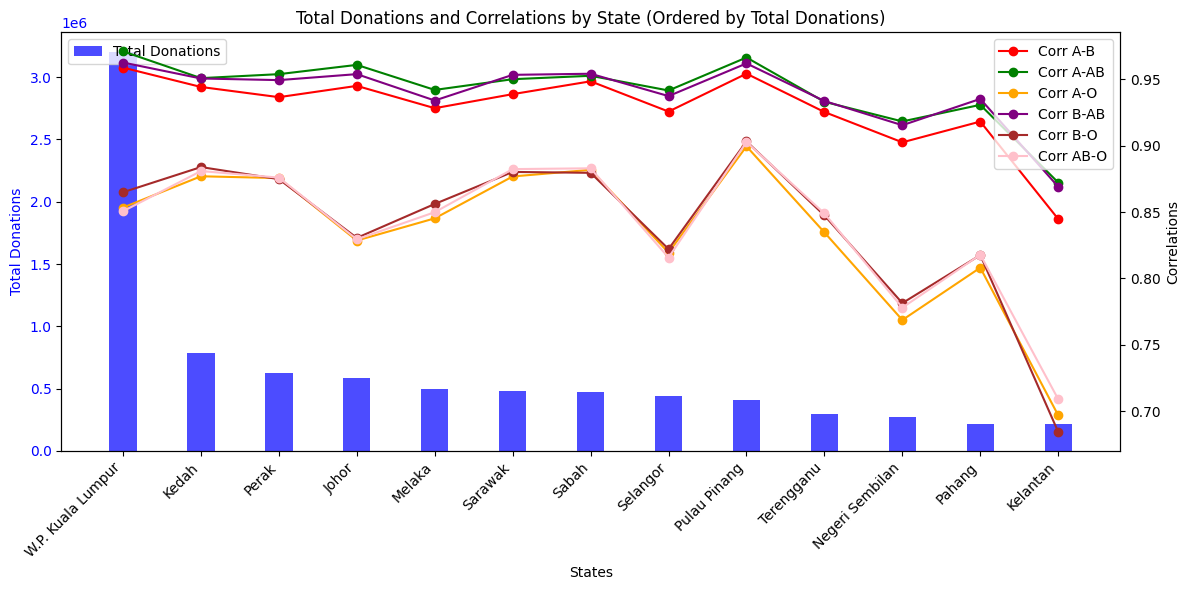

In [21]:
# Sort states and total_pop based on total_pop in descending order
sorted_indices = np.argsort(total_pop)[::-1]
states_sorted = [states[i] for i in sorted_indices]
total_pop_sorted = [total_pop[i] for i in sorted_indices]
corr_a_b_sorted = [corr_a_b[i] for i in sorted_indices]
corr_a_ab_sorted = [corr_a_ab[i] for i in sorted_indices]
corr_a_o_sorted = [corr_a_o[i] for i in sorted_indices]
corr_b_ab_sorted = [corr_b_ab[i] for i in sorted_indices]
corr_b_o_sorted = [corr_b_o[i] for i in sorted_indices]
corr_ab_o_sorted = [corr_ab_o[i] for i in sorted_indices]

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for total donations
bar_width = 0.35
x = np.arange(len(states_sorted))
ax1.bar(x, total_pop_sorted, bar_width, label='Total Donations', color='blue', alpha=0.7)
ax1.set_xlabel('States')
ax1.set_ylabel('Total Donations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(states_sorted, rotation=45, ha='right')

# Line plot for correlations
ax2 = ax1.twinx()
ax2.plot(x, corr_a_b_sorted, label='Corr A-B', marker='o', color='red')
ax2.plot(x, corr_a_ab_sorted, label='Corr A-AB', marker='o', color='green')
ax2.plot(x, corr_a_o_sorted, label='Corr A-O', marker='o', color='orange')
ax2.plot(x, corr_b_ab_sorted, label='Corr B-AB', marker='o', color='purple')
ax2.plot(x, corr_b_o_sorted, label='Corr B-O', marker='o', color='brown')
ax2.plot(x, corr_ab_o_sorted, label='Corr AB-O', marker='o', color='pink')
ax2.set_ylabel('Correlations', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add a title
plt.title('Total Donations and Correlations by State (Ordered by Total Donations)')

# Show the plot
plt.tight_layout()
plt.show()

It is interesting to see that correlation gets weaker the fewer observations we have.

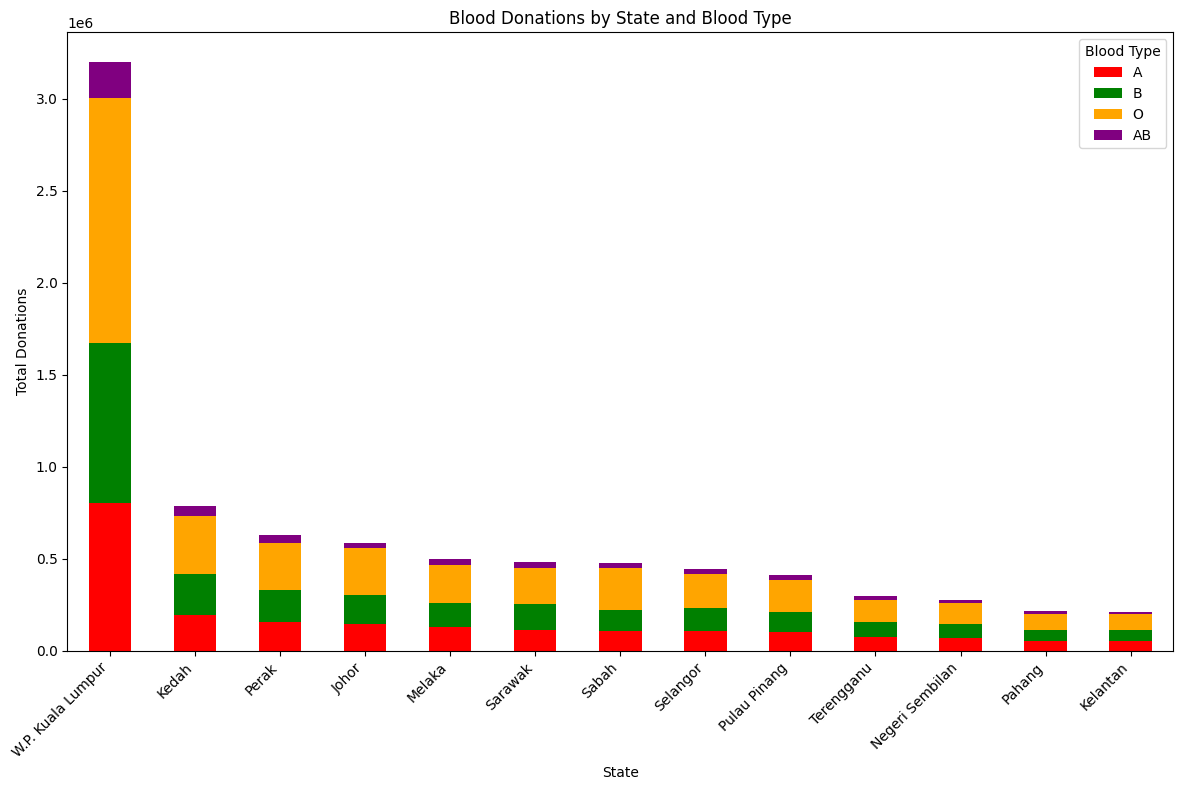

In [22]:
# Group data by state and sum donations for each blood type
grouped_state = analysis_df.group_by("state").agg([
    pl.col("a").sum().alias("A"),
    pl.col("b").sum().alias("B"),
    pl.col("o").sum().alias("O"),
    pl.col("ab").sum().alias("AB")
])

# Convert to pandas for easier plotting
grouped_state_pd = grouped_state.to_pandas()

# Add a column for total donations across all blood types
grouped_state_pd["Total"] = grouped_state_pd[["A", "B", "O", "AB"]].sum(axis=1)

# Sort the DataFrame by the total donations in descending order
grouped_state_pd = grouped_state_pd.sort_values(by="Total", ascending=False).drop(columns='Total')

# Plot a stacked bar chart
grouped_state_pd.set_index("state").plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
    color=["red", "green", "orange", "purple"]
)

plt.title("Blood Donations by State and Blood Type")
plt.xlabel("State")
plt.ylabel("Total Donations")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Blood Type")
plt.tight_layout()
plt.show()

# Investigating Data: Understanding Seasonality

In [23]:
# Getting a rolling mean for monthly smoothing
WINDOW_SIZE = constants.WINDOW_SIZE

analysis_df = analysis_df.with_columns(
    pl.col("all").rolling_mean(WINDOW_SIZE).alias("trend_all"),
    pl.col("a").rolling_mean(WINDOW_SIZE).alias("trend_a"),
    pl.col("b").rolling_mean(WINDOW_SIZE).alias("trend_b"),
    pl.col("ab").rolling_mean(WINDOW_SIZE).alias("trend_ab"),
    pl.col("o").rolling_mean(WINDOW_SIZE).alias("trend_o"),
)

In [24]:
analysis_df = analysis_df.with_columns(
    (pl.col("all") - pl.col("trend_all")).alias("detrended_all"),
    (pl.col("a") - pl.col("trend_a")).alias("detrended_a"),
    (pl.col("b") - pl.col("trend_b")).alias("detrended_b"),
    (pl.col("ab") - pl.col("trend_ab")).alias("detrended_ab"),
    (pl.col("o") - pl.col("trend_o")).alias("detrended_o")
)

In [25]:
analysis_df = analysis_df.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.week().alias("week"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

In [26]:
def group_dfs(df: pl.dataframe, group_col: str) -> pl.dataframe:
    
    return df.group_by(group_col).agg(
        pl.col("detrended_all").mean().alias("all_avg_seasonality"),
        pl.col("detrended_a").mean().alias("a_avg_seasonality"),
        pl.col("detrended_b").mean().alias("b_avg_seasonality"),
        pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
        pl.col("detrended_o").mean().alias("o_avg_seasonality")
    ).sort(group_col)
    
seasonality_by_dayofyear = group_dfs(analysis_df, 'day_of_year')
seasonality_by_weekday = group_dfs(analysis_df, 'weekday')
seasonality_by_month = group_dfs(analysis_df, 'month')
seasonality_by_week = group_dfs(analysis_df, 'week')
    

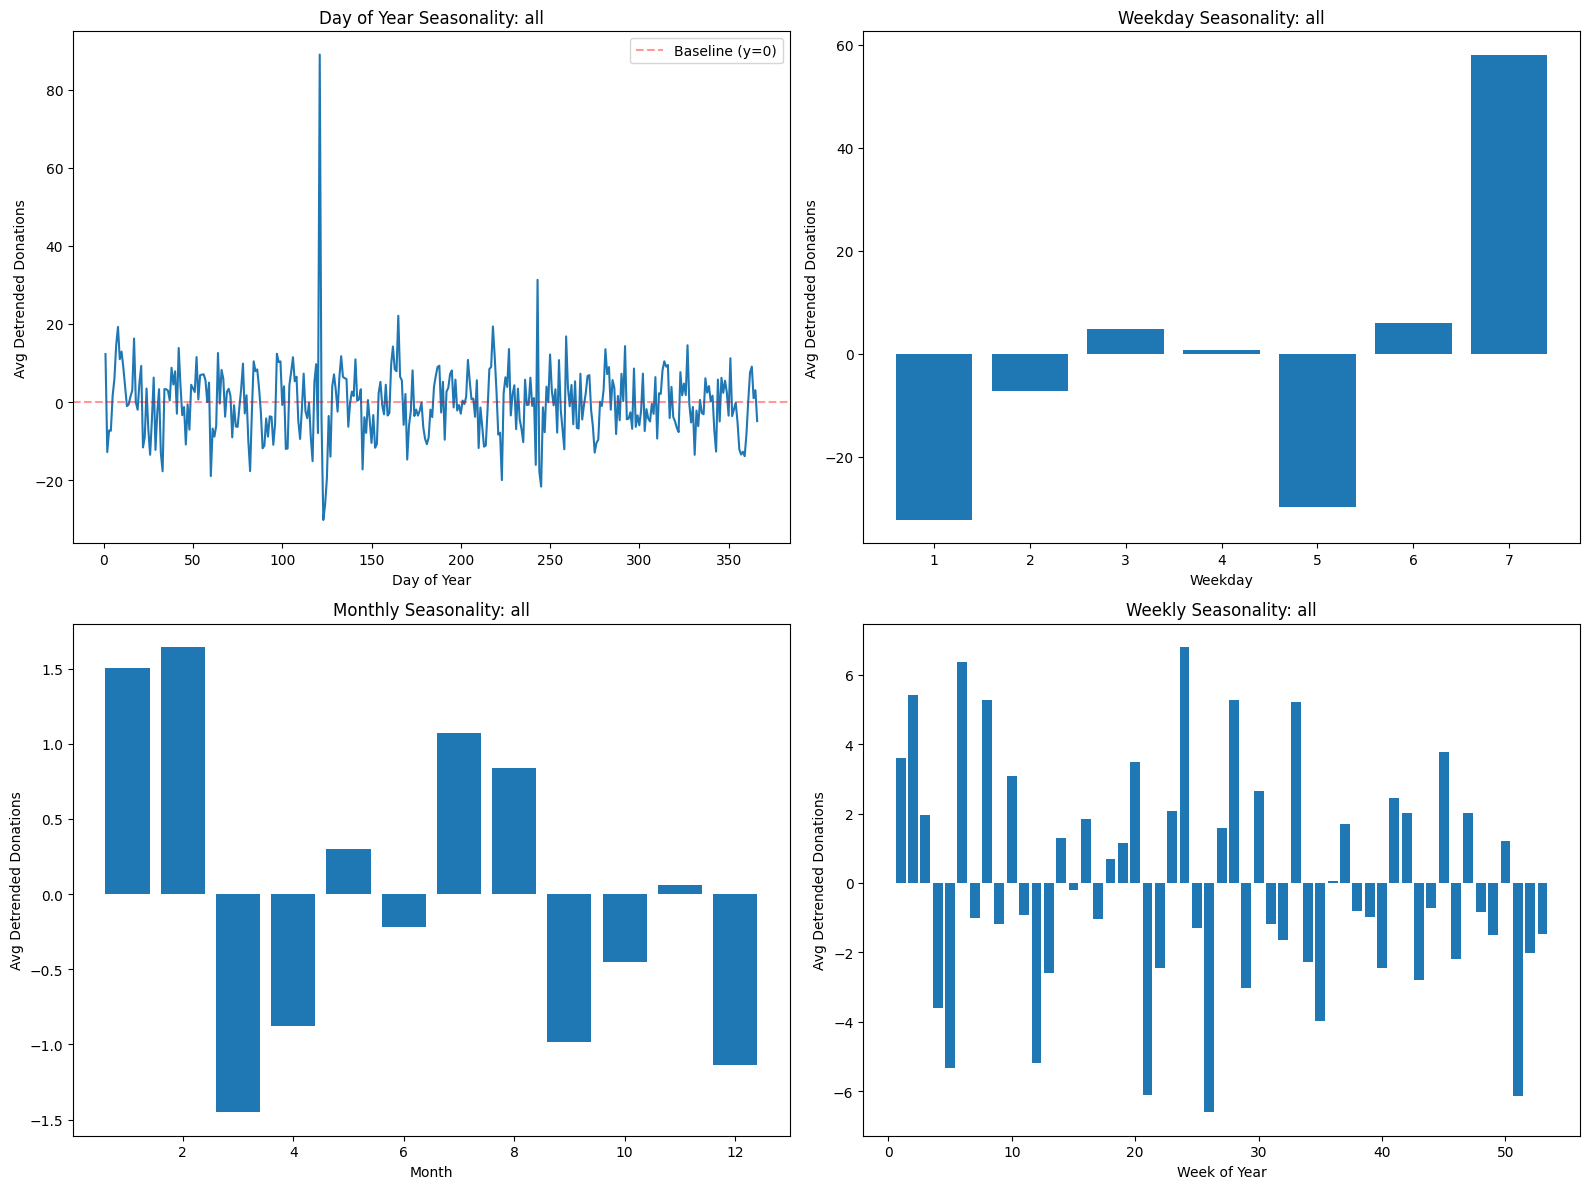

In [27]:
blood_type = 'all'
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
y_label = "Avg Detrended Donations"

# Yearly seasonality (day of year)
axes[0, 0].plot(seasonality_by_dayofyear["day_of_year"].to_numpy(), seasonality_by_dayofyear[f"{blood_type}_avg_seasonality"].to_numpy())
axes[0, 0].axhline(y=0, color='red', linestyle='--', label='Baseline (y=0)', alpha=0.4)
axes[0, 0].set_title(f"Day of Year Seasonality: {blood_type}")
axes[0, 0].set_xlabel("Day of Year")
axes[0, 0].set_ylabel(y_label)
axes[0, 0].legend()

# Weekday seasonality
axes[0, 1].bar(seasonality_by_weekday["weekday"].to_numpy(), seasonality_by_weekday[f"{blood_type}_avg_seasonality"].to_numpy())
axes[0, 1].set_title(f"Weekday Seasonality: {blood_type}")
axes[0, 1].set_xlabel("Weekday")
axes[0, 1].set_ylabel(y_label)

# Monthly seasonality
axes[1, 0].bar(seasonality_by_month["month"].to_numpy(), seasonality_by_month[f"{blood_type}_avg_seasonality"].to_numpy())
axes[1, 0].set_title(f"Monthly Seasonality: {blood_type}")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel(y_label)

# Weekly seasonality
axes[1, 1].bar(seasonality_by_week["week"].to_numpy(), seasonality_by_week[f"{blood_type}_avg_seasonality"].to_numpy())
axes[1, 1].set_title(f"Weekly Seasonality: {blood_type}")
axes[1, 1].set_xlabel("Week of Year")
axes[1, 1].set_ylabel(y_label)

plt.tight_layout()
plt.show()


In [28]:
# Analyze spike days
seasonality_by_dayofyear.sort("all_avg_seasonality", descending=True).head(10)

day_of_year,all_avg_seasonality,a_avg_seasonality,b_avg_seasonality,ab_avg_seasonality,o_avg_seasonality
i16,f64,f64,f64,f64,f64
121,89.00347,24.08849,21.973395,5.190862,37.750723
243,31.304029,8.114774,7.239316,1.775946,14.173993
165,22.105842,5.620012,6.389821,1.364951,8.731058
218,19.366911,4.961538,5.448718,1.04884,7.907814
8,19.249855,4.470214,5.469057,1.176981,8.133603
259,16.824786,3.968864,4.494505,1.105617,7.2558
17,16.277617,3.602082,4.784847,0.860035,7.030654
7,14.673222,3.160208,3.804511,0.803355,6.905147
327,14.554945,3.10989,4.67033,0.78022,5.994505


Very interesting to see this. 121st day of the year leads to by far the biggest spike. The explanation is relatively straightforward. Day number 121 is 1st of May, a public holiday. Given that people are not working on that day, they have capacity for donating blood. Also, for number 2, day 243 is August 31, Hari Merdeka (Independence Day) in Malaysia, which also gives people time to donate blood. 

In [29]:
analysis_df.select("date", "all").sort("all", descending=True).head(10)

date,all
date,i64
2007-02-11,2667
2014-05-01,1999
2007-02-01,1910
2006-02-11,1822
2017-02-09,1815
2014-03-02,1770
2018-05-01,1763
2019-05-01,1741
2014-01-17,1736


In [30]:
# Analyze spike days
seasonality_by_dayofyear.sort("all_avg_seasonality", descending=False).head(10)

day_of_year,all_avg_seasonality,a_avg_seasonality,b_avg_seasonality,ab_avg_seasonality,o_avg_seasonality
i16,f64,f64,f64,f64,f64
123,-30.19491,-7.825333,-7.352227,-1.878543,-13.138809
124,-26.317525,-6.935801,-6.765761,-1.604974,-11.010989
245,-21.64652,-5.494505,-5.578755,-1.361416,-9.211844
223,-19.985958,-5.215507,-5.163004,-1.235653,-8.371795
125,-19.580682,-4.951995,-4.876807,-1.117987,-8.633892
60,-18.967033,-4.578947,-5.419318,-1.339503,-7.629265
244,-17.799756,-4.725885,-4.581197,-1.240537,-7.252137
33,-17.731637,-3.549451,-5.559861,-1.210526,-7.411799
82,-17.678427,-4.044534,-4.582418,-0.994795,-8.05668


# Investigating holidays

In [31]:
holiday_data = [
    {"date": date, "name": name} for date, name in 
    holidays.country_holidays('MY', years = range(df['date'].min().year, df['date'].max().year + 1)).items()
]

malaysia_holidays_df = pl.DataFrame(holiday_data).filter(pl.col("name") != "Cuti tambahan sempena memperingati SAT 2017")
malaysia_holidays_df

date,name
date,str
2006-01-29,"""Tahun Baharu Cina"""
2006-01-30,"""Tahun Baharu Cina (Hari Kedua)"""
2006-05-12,"""Hari Wesak"""
2006-05-01,"""Hari Pekerja"""
2006-06-03,"""Hari Keputeraan Rasmi Seri Pad…"
…,…
2025-09-05,"""Hari Keputeraan Nabi Muhammad …"
2025-03-31,"""Hari Raya Puasa"""
2025-04-01,"""Hari Raya Puasa (Hari Kedua)"""


In [32]:
malaysia_holidays_df = malaysia_holidays_df.with_columns(
    pl.col("name").str.replace(r"\s*\(Hari Kedua\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace(r"\s*\(pergantian hari\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace(r"\s*\(pilihan raya umum\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace("Cuti ", "").alias("name")
)

In [33]:
df_all = df_all.join(malaysia_holidays_df, on='date', how='left').fill_null("No holiday")
df_all

date,a,b,o,ab,all,name
date,i64,i64,i64,i64,i64,str
2006-01-01,152,139,194,40,525,"""No holiday"""
2006-01-02,53,43,112,19,227,"""No holiday"""
2006-01-03,29,21,56,6,112,"""No holiday"""
2006-01-04,92,98,165,36,391,"""No holiday"""
2006-01-05,149,198,193,42,582,"""No holiday"""
…,…,…,…,…,…,…
2025-06-01,556,589,1056,65,2266,"""No holiday"""
2025-06-02,442,509,781,60,1792,"""Hari Keputeraan Rasmi Seri Pad…"
2025-06-03,282,293,460,49,1084,"""No holiday"""


In [34]:
holidays_dummies = df_all.select(pl.col("name").alias("h")).to_dummies()
holidays_dummies.head(5)

h_Awal Muharam,h_Hari Kebangsaan,h_Hari Kebangsaan; Hari Raya Puasa,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Pekerja; Hari Wesak,h_Hari Pertabalan Yang di-Pertuan Agong ke-15,h_Hari Pertabalan Yang di-Pertuan Agong ke-16,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_No holiday,h_Peristiwa,h_Tahun Baharu Cina
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [35]:
df_all = pl.concat([df_all.drop('name'), holidays_dummies], how="horizontal")
df_all.head(5)

date,a,b,o,ab,all,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Kebangsaan; Hari Raya Puasa,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Pekerja; Hari Wesak,h_Hari Pertabalan Yang di-Pertuan Agong ke-15,h_Hari Pertabalan Yang di-Pertuan Agong ke-16,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_No holiday,h_Peristiwa,h_Tahun Baharu Cina
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2006-01-01,152,139,194,40,525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-02,53,43,112,19,227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-03,29,21,56,6,112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-04,92,98,165,36,391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-05,149,198,193,42,582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
def handle_duplicate_holidays(df, double_name, name_1, name_2):
    return df.with_columns(
        (pl.col(name_1) | pl.col(double_name)).alias(name_1),
        (pl.col(name_2) | pl.col(double_name)).alias(name_2)
    ).drop(double_name)

In [37]:
df_all = handle_duplicate_holidays(df_all, 'h_Hari Pekerja; Hari Wesak', 'h_Hari Pekerja', 'h_Hari Wesak')
df_all = handle_duplicate_holidays(df_all, 'h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia', 'h_Hari Keputeraan Nabi Muhammad S.A.W.', 'h_Hari Malaysia')
df_all = handle_duplicate_holidays(df_all, 'h_Hari Kebangsaan; Hari Raya Puasa', 'h_Hari Kebangsaan', 'h_Hari Raya Puasa')

df_all = df_all.with_columns(
    (pl.col('h_Hari Pertabalan Yang di-Pertuan Agong ke-15') | pl.col('h_Hari Pertabalan Yang di-Pertuan Agong ke-16')).alias('h_Hari Pertabalan Yang di-Pertuan Agong')
).drop('h_Hari Pertabalan Yang di-Pertuan Agong ke-15', 'h_Hari Pertabalan Yang di-Pertuan Agong ke-16')


In [38]:
df_all = df_all.drop(['h_No holiday'])
df_all.head(5)

date,a,b,o,ab,all,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_Peristiwa,h_Tahun Baharu Cina,h_Hari Pertabalan Yang di-Pertuan Agong
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2006-01-01,152,139,194,40,525,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-02,53,43,112,19,227,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-03,29,21,56,6,112,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-04,92,98,165,36,391,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-05,149,198,193,42,582,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
df_all.filter(pl.col('h_Peristiwa') == 1)

date,a,b,o,ab,all,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_Peristiwa,h_Tahun Baharu Cina,h_Hari Pertabalan Yang di-Pertuan Agong
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2018-05-09,7,15,23,5,50,0,0,0,0,0,0,0,0,0,0,1,0,0
2022-11-18,199,200,305,37,741,0,0,0,0,0,0,0,0,0,0,1,0,0
2022-11-19,62,62,120,25,269,0,0,0,0,0,0,0,0,0,0,1,0,0
2022-11-28,217,247,360,50,874,0,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
# Select columns starting with 'h_' and the 'all' donations column
holiday_cols = [col for col in df_all.columns if col.startswith('h_')]
means = {}
counts = {}

val_size = int(df_all.height * (constants.TRAIN_FRAC + constants.VAL_FRAC))

for col in holiday_cols:
    mask = pl.col(col) == 1
    mean_donation = df_all[:val_size].filter(mask)['all'].mean()
    count = df_all[:val_size].filter(mask).height
    means[col] = mean_donation
    counts[col] = count

# Convert to a sorted DataFrame for easier viewing
mean_donations_df = pl.DataFrame({
    "holiday": list(means.keys()),
    "mean_all_donations": list(means.values()),
    "count": [counts[col] for col in means.keys()]
}).sort("mean_all_donations", descending=True)

In [41]:
mean_donations_df.head(5)

holiday,mean_all_donations,count
str,f64,i64
"""h_Hari Pekerja""",2654.772727,22
"""h_Hari Wesak""",2328.045455,22
"""h_Hari Malaysia""",1729.0625,16
"""h_Hari Kebangsaan""",1635.75,20
"""h_Hari Keputeraan Rasmi Seri P…",1245.05,20


In [42]:
mean_donations_df.tail(5)

holiday,mean_all_donations,count
str,f64,i64
"""h_Hari Pertabalan Yang di-Pert…",873.5,2
"""h_Tahun Baharu Cina""",684.608696,46
"""h_Peristiwa""",483.5,4
"""h_Hari Raya Qurban""",311.181818,22
"""h_Hari Raya Puasa""",173.933333,45


Ok, so we now know that these three days are high donation holidays:
- Hari Pekerja
- Hari Wesak
- Hari Malaysia
- Hari Kebangsaan

And we can flag the following three days as low donation holidays:
- Hari Raya Puasa
- Hari Raya Qurban
- Peristiwa

In [43]:
# We will thus group them as such
religion_or_culture_holidays = [
    'h_Awal Muharam',
    'h_Hari Keputeraan Nabi Muhammad S.A.W.',
    'h_Hari Krismas',
    'h_Tahun Baharu Cina',
    'h_Hari Raya Puasa',
    'h_Hari Raya Qurban',
    'h_Hari Wesak',
]

other_holidays = [
    'h_Hari Pekerja',
    'h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong',
    'h_Hari Pertabalan Yang di-Pertuan Agong',
    'h_Peristiwa',
    'h_Hari Malaysia',
    'h_Hari Kebangsaan',
]

low_donation_holidays = [
    'h_Hari Raya Puasa',
    'h_Hari Raya Qurban',
    'h_Peristiwa',
]

high_donation_holidays = [
    'h_Hari Pekerja',
    'h_Hari Wesak',
    'h_Hari Malaysia',
    'h_Hari Kebangsaan',
]

In [44]:
df_all = (
    df_all
    .with_columns(
    reduce(
        lambda acc, col: acc | pl.col(col),
        religion_or_culture_holidays[1:],
        pl.col(religion_or_culture_holidays[0])
    ).alias("is_religion_or_culture_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        other_holidays[1:],
        pl.col(other_holidays[0])
    ).alias("is_other_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        low_donation_holidays[1:],
        pl.col(low_donation_holidays[0])
    ).alias("is_low_donation_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        high_donation_holidays[1:],
        pl.col(high_donation_holidays[0])
    ).alias("is_high_donation_holiday")
    )
).drop(
    *religion_or_culture_holidays,
    *other_holidays,
    *low_donation_holidays,
    *high_donation_holidays
)

In [45]:
with open("df_all.pkl", "wb") as file:
    pickle.dump(df_all, file)